# EE5934 Deep Learning Project 1

In this project, you are going to explore Deep Learning and Neural Networks by completing the following three tasks:

* Task 1. Network Exploration (30%)
* Task 2. Model Interpretation (30%)
* Task 3. Adversarial Attack (40%)

Before doing the project, please read the instructions carefully (failure to do so will be penalized):

1. Implement your codes **within** "TODO" and "END OF YOUR CODE", do **NOT** modify any codes outside the answer area;
2. Make sure your codes **clean**, **easily readable** (add meaningful comments if needed), and **runnable**;
3. Write your answers in the given markdown cells, keep your answers clear and concise;
4. Do submit your project to "Files/Project 1/Submissions" on [LumiNUS](https://luminus.nus.edu.sg/) before the deadline: **5:59 pm (SGT), 6 March, 2022**;
5. This is an individual project, do **NOT** share your solutions with others, we have zero tolerance for cheating.

If you have any questions regarding this project, please feel free to contact Wu Zhangjie (zhangjiewu@u.nus.edu). 

## Preparation

### Loading packages

Please install the packages listed below if you haven't done so. To avoid unnecessary trouble while reproducing your code, please install the required [PyTorch](https://pytorch.org/) version.

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as mpl_color_map
from PIL import Image
from random import randint

import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision

assert torch.__version__ == '1.9.0', 'Please reinstall pytorch to 1.9.0.'
assert torchvision.__version__ == '0.10.0', 'Please reinstall torchvision to 0.10.0.'

### Checking the Running Device

It is recommended to run this notebook on GPUs since that would be a much faster way to train and evaluate the model. If you have difficulties accessing GPUs with your machine, you can choose to use the free GPUs provided by [Google Colab](https://colab.research.google.com/).

In [2]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'
print(device)

cuda:0


In [4]:
# Certificate verification was cancelled globally
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Getting the CIFAR-10 Dataset

In [3]:
CIFAR_CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
CIFAR_MEAN, CIFAR_STD = np.array([0.4914, 0.4822, 0.4465]), np.array([0.247, 0.243, 0.261])

# Convert image to pytroch tensor and normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=CIFAR_MEAN.tolist(), std=CIFAR_STD.tolist())
])

# Inverse operation to regain original image
inverse_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=[0, 0, 0], std=(1 / CIFAR_STD).tolist()),
    torchvision.transforms.Normalize(mean=(-CIFAR_MEAN).tolist(), std=[1, 1, 1]),
    torchvision.transforms.ToPILImage()
])

# Load dataset
train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_size = len(train_set)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

Files already downloaded and verified
Files already downloaded and verified


### Helper Fuctions

In [5]:
def show_prob_cifar(image, label, p):
    """
        Show image and prediction probability for CIFAR-10 dataset.
    Args:
    Inputs
        image (Tensor): Input image
        label (int): The ground truth label of input image
        p (Tensor): Class probability of input image
    
    """

    ft = 10
    width = 0.9
    col = 'blue'

    p=p.cpu().data.squeeze().numpy()
    y_pos = np.arange(len(p))
    fig = plt.figure(figsize=(5, 5))

    # Plot image
    ax1 = plt.subplot(2, 1, 1)
    ax1.imshow(image)
    ax1.set_axis_off()
    ax1.set_title('Ground Truth: ' + CIFAR_CLASSES[label])

    # Plot probability
    ax2 = plt.subplot(2, 1, 2)
    ax2.barh(y_pos, p*0.1, width , align='center', color=col)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(CIFAR_CLASSES, fontsize=ft)
    ax2.invert_yaxis()  
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_linewidth(4)
    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax2.text(p[i]*0.1 + 0.001, y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax2.transData, color= col,fontsize=ft)

    plt.show()


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

## Task 1: Network Exploration

In this task, you are expected to build a convolutional neural network (CNN) for solving a problem of image recognition and explore strategies that could further strengthen its performance.  

### Defining the Model

In deep learning, a Convolutional Neural Network (CNN, or ConvNet) is one of the most famous deep learning models that have been widely used in the field of computer vision. A simple CNN often consists of three main types of layers:
- **Convolutional Layer**, the core building block that takes over the most of computational burdens, contains a set of filters (or kernels) with learnable parameters while training. It receives as input an image (or a feature map), and computes its output volume by stacking the activation maps convolved by every filter along the depth dimension. 
- **Pooling Layer** is commonly inserted in-between successive Conv layers in a CNN architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
- **Fully Connected Layer** have fully connections to all activations in the previous layer and is usually placed before the output layer to form the last few layers of a CNN Architecture.

If you are not familiar with CNN architectures, [this blog](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) may help you get a better understanding of the mechanism of each layer.

Define a naive CNN stacked by the layers mentioned above. While doing so, please follow the TODOs provided below. (Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html) for detailed instructions of building basic blocks with PyTorch.)

In [6]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ##############################################################################
        # TODO: Define a simple CNN contraining Conv, Pooling, and FC layers.        #
        ##############################################################################
        
        # Block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(3, 3), stride=1, padding=1)
        # Block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        # Block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3 = torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1)
        # Block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4 = torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=1, padding=1)
        
        # Linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        self.fc1 = torch.nn.Linear(in_features=512 * 2 * 2, out_features=4096)
        self.fc2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = torch.nn.Linear(in_features=4096, out_features=10)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        
        ##############################################################################
        # TODO: Implement forward path turning an input image to class probability.  #
        # For activation function, please use ReLU.                                  #
        ##############################################################################

        # Block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2) # Max pooling over a (2, 2) window
        # Block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) # Max pooling over a (2, 2) window
        # Block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2) # Max pooling over a (2, 2) window
        # Block 4:         256 x 4 x 4 --> 512 x 2 x 2
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2) # Max pooling over a (2, 2) window
        
        # Linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
        return x

model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)


### Training the Model

Some default settings for training. 

In [7]:
# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.25

# Set up optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
# Build data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
data_loaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": train_size, "test": test_size}

Here, your job is to implement two functions for training and testing model.

In [8]:
def eval_on_test_set(model):
    model.eval()
    running_error = 0

    for data in test_loader:
        pass
        ##############################################################################
        # TODO: Implement the evaluation process on test set.                        #
        ##############################################################################

        # Load inputs and labels and deploy to running device
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Forward batch data through the net
        outputs = model(inputs)
        # Compute the error made on this batch and add it to the running error
        batch_error = (outputs.argmax(1) != labels).sum()
        running_error = running_error + batch_error
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
    total_error = running_error / test_size
    print('error rate on test set = {:.2f}%'.format(total_error * 100))
    model.train()

In [9]:
def train_net(model):
    start=time.time()
    model.train()

    for epoch in range(epochs):
        # set the running quatities to zero at the beginning of the epoch
        running_loss = 0
        running_error = 0
    
        for data in train_loader:
            pass
            ##############################################################################
            # TODO: Implement the training process.                                      #
            ##############################################################################

            # Load inputs and labels and deploy to running device
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Set the gradients to zeros
            optimizer.zero_grad()
            # Forward the batch data through the net       
            outputs = model(inputs)
            # Compute the average of the losses of the data points in the minibatch
            loss = criterion(outputs, labels)
            # Backward pass to compute gradients
            loss.backward()
            # Do one step of stochastic gradient descent
            optimizer.step()
            # Add the loss of this batch to the running loss
            running_loss = running_loss + loss.item()
            # Compute the error made on this batch and add it to the running error
            batch_error = (outputs.argmax(1) != labels).sum()
            running_error = running_error + batch_error
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
        # Compute stats for the full training set
        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        eval_on_test_set(model) 

Run `train_net` and start training. After training, your error on the testing set should be under 30% (if not, please look back and check your codes, there might be something wrong with the network architecture or training process). Once the training phrase is completed, save the trained model on your device so it can be directly loaded in the following tasks.

In [10]:
# Start training
train_net(model)
# Save the trained model
torch.save(model.state_dict(), './model_cnn.pt')

epoch= 0 	 time= 0.20 min 	 loss= 0.015 	 error= 70.53%
error rate on test set = 58.54%
epoch= 1 	 time= 0.42 min 	 loss= 0.011 	 error= 50.62%
error rate on test set = 51.47%
epoch= 2 	 time= 0.64 min 	 loss= 0.008 	 error= 37.44%
error rate on test set = 33.74%
epoch= 3 	 time= 0.86 min 	 loss= 0.007 	 error= 29.39%
error rate on test set = 34.66%
epoch= 4 	 time= 1.08 min 	 loss= 0.005 	 error= 22.80%
error rate on test set = 27.54%
epoch= 5 	 time= 1.30 min 	 loss= 0.004 	 error= 17.28%
error rate on test set = 30.90%
epoch= 6 	 time= 1.52 min 	 loss= 0.003 	 error= 13.02%
error rate on test set = 23.95%
epoch= 7 	 time= 1.74 min 	 loss= 0.002 	 error= 9.13%
error rate on test set = 25.10%
epoch= 8 	 time= 1.96 min 	 loss= 0.002 	 error= 6.87%
error rate on test set = 23.97%
epoch= 9 	 time= 2.18 min 	 loss= 0.001 	 error= 4.97%
error rate on test set = 30.20%
epoch= 10 	 time= 2.40 min 	 loss= 0.001 	 error= 4.00%
error rate on test set = 23.55%
epoch= 11 	 time= 2.62 min 	 loss= 

### Ploting the Results

Now you have finished model training, let's randomly pick some test images, feed them into your model and see how they turn out. (There is nothing to implement in this section.)

In [11]:
assert os.path.exists('./model_cnn.pt'), 'train the model first'
# Load the trained model
model.load_state_dict(torch.load('./model_cnn.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
)

7742


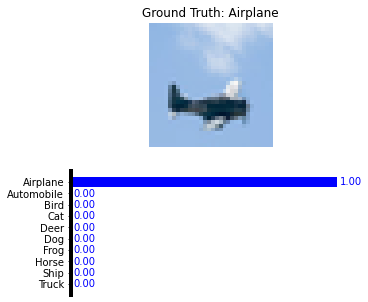

In [13]:
# Choose a picture at random
idx = randint(0, test_size-1)
print(idx)
im, label = test_set[idx]
org_im = inverse_transform(im)

# Send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = im.view(1,3,32,32)

# Feed it to the net and display the confidence scores
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

### Refining the Model

Although the vallina model has achieved fair classification results, the test error is still high remaining huge room for further improvement. There are lots of methods to refine your model, such as **modifying the network architecture** (e.g., making your network deeper), **optimizing the learning strategy** (e.g., optimizer, loss function), and **tuning the hyperparameters** (e.g., learning rate, training iterations), etc. Please try at least **TWO** different methods to improve your model's performance, and discuss why these changes can work. Design and conduct your own experiments using the coding cell below, and present your experimental results and analysis in a decent way (e.g., drawing some neat figures/tables can help to convey your thoughts effectively). 

In [14]:
##############################################################################
# TODO: Conduct experiments to refine your model (e.g., modify the backbone, #
# alter the learning strategy, and tuning the hyperparameters, etc.).        #
##############################################################################

# your code

# I add the weight_decay to regularize the model and decrease the learning rate
epochs = 20
model_1 = ConvNet()
model_1.to(device)
optimizer = optim.SGD(model_1.parameters(), lr=0.1, weight_decay=0.001)
train_net(model_1)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

epoch= 0 	 time= 0.19 min 	 loss= 0.015 	 error= 72.84%
error rate on test set = 67.98%
epoch= 1 	 time= 0.47 min 	 loss= 0.012 	 error= 55.03%
error rate on test set = 48.16%
epoch= 2 	 time= 0.77 min 	 loss= 0.010 	 error= 45.25%
error rate on test set = 41.95%
epoch= 3 	 time= 1.00 min 	 loss= 0.008 	 error= 37.60%
error rate on test set = 35.59%
epoch= 4 	 time= 1.22 min 	 loss= 0.007 	 error= 31.22%
error rate on test set = 29.47%
epoch= 5 	 time= 1.45 min 	 loss= 0.006 	 error= 26.62%
error rate on test set = 27.75%
epoch= 6 	 time= 1.67 min 	 loss= 0.005 	 error= 22.77%
error rate on test set = 25.29%
epoch= 7 	 time= 1.90 min 	 loss= 0.004 	 error= 19.01%
error rate on test set = 25.09%
epoch= 8 	 time= 2.13 min 	 loss= 0.004 	 error= 15.76%
error rate on test set = 27.51%
epoch= 9 	 time= 2.35 min 	 loss= 0.003 	 error= 12.58%
error rate on test set = 25.27%
epoch= 10 	 time= 2.59 min 	 loss= 0.002 	 error= 9.93%
error rate on test set = 24.32%
epoch= 11 	 time= 2.82 min 	 los


---

**Write your observations and analysis in this Markdown cell:**

We can see the original result is overfitting, which error rate on train set is much smaller than it on test set. So we need to prevent the overfitting. I try add the weight_decay to regularize the optimizer and decrease the learning rate. The refined model has a bit improve on test set, the error rate decrease from 23.03% to 22.15%.

---

## Task 2: Model Interpretation

The model is doing well, eating images and predicting results; however, everything that happens inside is opaque and hard to explain. So, how can we interpret how CNN sees and understands when making a decision? 

In this section, we are going to explore Grad-CAM, a visual explanation algorithm that generates heatmaps indicating where the network is "looking" in the forward pass.

#### Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM) [1], uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. An overview of the workflow of Grad-CAM is shown below. Please read the paper [1], understand the algorithm, and implement `generate_cam`.

<img src="./figures/gradcam_network.png" width="800"/>

[1] [Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." ICCV 2017.](https://arxiv.org/abs/1610.02391)

In [15]:
def get_features_hook(self,input,output):
    features.append(output.data.cpu().numpy())

def get_grads_hook(self,input_grad, output_grad):
    gradients.append(output_grad[0].data.cpu().numpy())

features  = []

In [16]:
gradients = []  # A gloabl variable used to save the gradient
def generate_cam(model, input_image, target_layer='conv4a', target_class=None):
    """
    A function to generate Grad-CAM of specific layer and class on an input image using given model.
  
    Inputs
    - model: A PyTorch model.
    - input_image: A PyTorch Tensor of shape (1, C, H, W).
    - target_layer: A String indicating the name of targeted convolutional layer being visualized (e.g., 'conv4').
                    By default, use the last conv layer of the model.
    - target_class: An Integer indicating the lable of targeted class being visualized (e.g., 1). 
                    If None, use the predicted class as target class.
    
    Returns: A NumPy Array of shape (N, C, H, W) showing the intended heatmap.
    """

    ##############################################################################
    # TODO: Given an input image, generate its Grad-CAM on target conv layer     #
    # using the backward gradients from a specific class.                        #
    # 1. Forward the input image, when you also need to register the gradient    #
    # hook so as to get the gradient in backward pass (hint: register_hook).     #
    # 2. Backward pass with specified target class, and get gradients.           #
    # 3. Average each gradient, multiply with its conv output, and sum together. #
    ##############################################################################
    
    # your code

    # register the gradient hook
    handle_feat_conv1 = model.conv1.register_forward_hook(get_features_hook) # conv1
    handle_grad_conv1 = model.conv1.register_backward_hook(get_grads_hook)
    handle_feat_conv2 = model.conv2.register_forward_hook(get_features_hook) # conv2
    handle_grad_conv2 = model.conv2.register_backward_hook(get_grads_hook)
    handle_feat_conv3 = model.conv3.register_forward_hook(get_features_hook) # conv3
    handle_grad_conv3 = model.conv3.register_backward_hook(get_grads_hook)
    handle_feat_conv4 = model.conv4.register_forward_hook(get_features_hook) # conv4
    handle_grad_conv4 = model.conv4.register_backward_hook(get_grads_hook)
    
    outputs = model(input_image) 
    pred_class = torch.argmax(outputs, dim=1)
    if isinstance(target_class,int):
        pass
    else:
        target_class = pred_class
    outputs[:,target_class].backward()
    
    target_layer = int(''.join(num for num in target_layer if num.isdigit()))
    grad = gradients[4-target_layer]
    feat = features[target_layer-1]
    _,c,_,_ = feat.shape
    for i in range(c):
      feat[:, i, :, :] *= grad[:, i, :, :]
    cam = torch.mean(torch.from_numpy(feat), dim=1).squeeze().numpy()
    
    # remove hook
    handle_feat_conv1.remove()
    handle_grad_conv1.remove()
    handle_feat_conv2.remove()
    handle_grad_conv2.remove()
    handle_feat_conv3.remove()
    handle_grad_conv3.remove()
    handle_feat_conv4.remove()
    handle_grad_conv4.remove()
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    # Post processing
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
    cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                    input_image.shape[3]), Image.ANTIALIAS))

    return cam

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


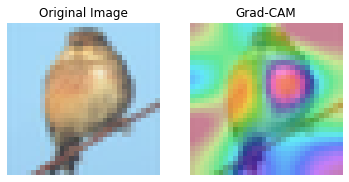

In [18]:
idx = randint(0, test_size-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

ax = plt.subplot(1, 2, 1)
ax.imshow(org_im)
ax.set_title('Original Image')
ax.set_axis_off()

cam = generate_cam(model, im)
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 2, 2)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM')
ax.set_axis_off()

### Performing Visual Explanation

Now you have successfully built a powerful tool (i.e., Grad-CAM) that can assist you to visualize and understand the CNN models. Try to make full use of `generate_cam` and design at least **TWO** experiments that can further explain how CNN sees and understands the images. For example, apply Grad-CAM on different layers and compare their differences. Please quantitatively show some evidence (e.g., plotting some examplar images clearly and elegantly) with necessary code snippets, write down your observations and briefly explain each. 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


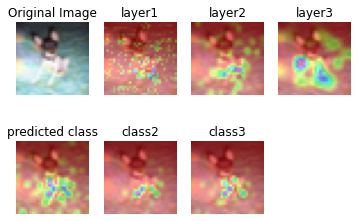

In [19]:
##############################################################################
# TODO: Write code snippets to present your experiments (hint: if you want   #
# to plot multiple images in one single figure, plt.subplot should help).    #
##############################################################################

# your code

# experiment1:try different layers
idx = randint(0, test_size-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

ax = plt.subplot(2, 4, 1)
ax.imshow(org_im)
ax.set_title('Original Image')
ax.set_axis_off()

cam = generate_cam(model, im, target_layer='conv1a')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(2, 4, 2)
ax.imshow(heatmap_on_image)
ax.set_title('layer1')
ax.set_axis_off()

cam = generate_cam(model, im, target_layer='conv2a')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(2, 4, 3)
ax.imshow(heatmap_on_image)
ax.set_title('layer2')
ax.set_axis_off()

cam = generate_cam(model, im, target_layer='conv3a')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(2, 4, 4)
ax.imshow(heatmap_on_image)
ax.set_title('layer3')
ax.set_axis_off()

# experiment1:try different target_classes

cam = generate_cam(model, im, target_layer='conv2a')
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(2, 4, 5)
ax.imshow(heatmap_on_image)
ax.set_title('predicted class')
ax.set_axis_off()

cam = generate_cam(model, im, target_layer='conv2a', target_class=1)
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(2, 4, 6)
ax.imshow(heatmap_on_image)
ax.set_title('class2')
ax.set_axis_off()

cam = generate_cam(model, im, target_layer='conv2a', target_class=2)
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
ax = plt.subplot(2, 4, 7)
ax.imshow(heatmap_on_image)
ax.set_title('class3')
ax.set_axis_off()

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**

From experiment1, we can see that different layer of CNN has different understands of the images. With the deepening of network layers, the height and width of features become smaller and smaller, Grad-CAM starts as a point of dispersion became a point of concentration. At the same time, feature region of deeper layer is larger, indicating the gradual increase of local receptive field.

From experiment2, we can see that different lable of targeted classes being visualized have different understand of focus on images. 
                    
---

## Task 3: Adversarial Attack

After going through some testing results in Task 1, you might think in most cases the model performs pretty well, predicting the correct classes with high confidence, and rarely making mistakes. However, the network is not as strong as you think. The network can be vulnerable and easily fooled by simply adding some very small distributions on input images. In this section, we are going to attack our previously trained model by generating adversarial images that visually look alike but crush the model without striking a blowing.

### Adversarial Examples

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These examples are usually generated by adding imperceptible non-random perturbations to the image, which are indistinguishable to human eye, but can cause the network to fail to identify the contents of the image. There are many kinds of such attack strategies, here we focus on the **Fast Gradient Sign Method (FGSM)** [2]. FGSM is a white box attack where the attacker has complete access to the model being attacked. The method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. Below shows a famous exmaple taken from the paper [2], where the classification of image showing "panda" is changed to "gibbon" after adding an imperceptibly small vector: $\text{sign}(\nabla_xJ(\theta, x, y))$.

<img src="./figures/adversarial_example.png" width="800"/>

Read the paper [2] for more details, and then implement the following function `generate_adv_image`, which generates "fooling images" of target class to attack your network. 

[2] [Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.](https://arxiv.org/abs/1412.6572)

In [20]:
def generate_adv_image(model, inputs, labels, targets=None, eps=0.07):
    """
    A function to generate adversarial examples.
  
    Inputs
    - model: A PyTorch model.
    - inputs: Input images, a PyTorch Tensor of shape (N, C, H, W).
    - labels: Ground truth labels of input images, a PyTorch Tensor of shape (N,).
    - targets: The target classes you want the model to misclassify, a PyTorch Tensor of shape (N,).
    
    Returns: The adversarial examples of given images.
    """


    ##############################################################################
    # TODO: Implement Fast Gradient Sign Method to generate an adversarial image #
    # that fools the model to predict incorrect class.                           #   
    # 1. Get the gradients of the loss w.r.t to the input image.                 #
    # 2. Get the sign of the gradients to create the perturbation.               #
    # 3. Add the perturbation to the input image.                                #
    ##############################################################################
    
    # your code
    
    if isinstance(labels,int):
      labels = torch.LongTensor([labels])
    inputs = inputs.to(device)
    labels = labels.to(device)
    inputs.requires_grad = True
            
    outputs = model(inputs)
    
    model.zero_grad()
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(outputs, labels).to(device)
    loss.backward()
    
    adv_inputs = inputs + eps*inputs.grad.sign()
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    return adv_inputs.detach()

### Attacking the Model

Randomly pick up some images from test set, and attack the model using adversarial examples generated by `generate_adv_image`.

Before attack:


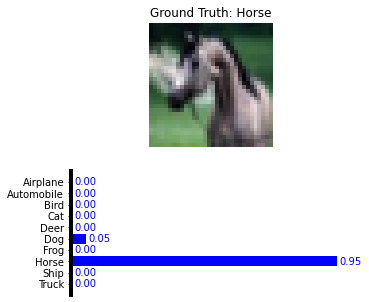

After attack:


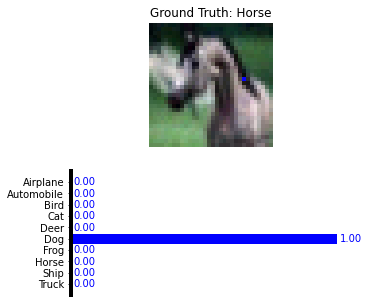

In [21]:
idx = randint(0, len(test_set)-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

print('Before attack:')
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

adv_im = generate_adv_image(model, im, label)

print('After attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

Run evaluation on the testing set to see how the model performs on the generated adversarial examples, and compare with results before attacks. Try different parameters (e.g., `targets`, `eps`), describe your observations with a brief explanation in the below cell. 

In [22]:
##############################################################################
# TODO: Evaluate error rate on adversarial images generated from testing set #
# with different parameter settings.                                         #
##############################################################################

# your code
def adversarial_eval_on_test_set(model, eps):
  model.eval()
  running_error = 0

  for data in test_loader:
    # Load inputs and labels and deploy to running device
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Forward batch data through the net
    adv_im = generate_adv_image(model, inputs, labels, eps=eps)
    outputs = model(adv_im)
    # Compute the error made on this batch and add it to the running error
    batch_error = (outputs.argmax(1) != labels).sum()
    running_error = running_error + batch_error

  total_error = running_error / test_size
  print('Eps = {:.3f}, error rate on test set = {:.2f}%'.format(eps, total_error * 100))

for eps in [0.007, 0.01, 0.07, 0.1, 0.7, 1, 7]:
  adversarial_eval_on_test_set(model, eps)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Eps = 0.007, error rate on test set = 32.73%
Eps = 0.010, error rate on test set = 36.75%
Eps = 0.070, error rate on test set = 70.92%
Eps = 0.100, error rate on test set = 73.85%
Eps = 0.700, error rate on test set = 82.92%
Eps = 1.000, error rate on test set = 84.29%
Eps = 7.000, error rate on test set = 88.92%


---

**Write your observations and analysis in this Markdown cell:**

We can see from the result, with the increasing of eps, the error rate on test set is larger. That's show that because of the eps get larger, attacked images are more distorted, make original model harder to classify.

---